# DataJoint Elements for 2-Photon Calcium Imaging

#### Open-source data pipeline for processing and analyzing fluorescent imaging datasets.

Welcome to the tutorial for the DataJoint Element for calcium imaging. This tutorial
aims to provide a comprehensive udnerstanding of the open-source data pipeline created
using `element-calcium-imaging`.

This package is designed to seamlessly process, ingest, and track calcium imaging data,
along with its associated parameters such as those used for image segmentation or motion
correction, and scan-level metadata. By the end of this tutorial you will have a clear
grasp on setting up and integrating `element-calcium-imaging` into your specific
research projects and lab.

![flowchart](../images/flowchart.svg)

### Prerequisites

Please see the [datajoint tutorials GitHub
repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before
proceeding.

A basic understanding of the following DataJoint concepts will be beneficial to your
understanding of this tutorial: 
1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method. 

#### **Tutorial Overview**

+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* subject, session, and scan metadata.
+ *Populate* scan-level metadata from image files.
+ Run the image processing task.
+ Curate the results (optional).
+ Visualize the results.

### **Setup**

This tutorial examines calcium imaging data acquired with `ScanImage` and processed via
`suite2p`. The goal is to store, track, and manage sessions of calcium imaging data,
including all outputs of image segmentations, fluorescence traces and deconvolved
activity traces. 

The results of this Element can be combined with **other modalities** to create
a complete, customizable data pipeline for your specific lab or study. For instance, you
can combine `element-calcium-imaging` with `element-array-ephys` and
`element-deeplabcut` to characterize the neural activity along with markless
pose-estimation during behavior.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

If the tutorial is run in Codespaces, a private, local database server is created and
made available for you. This is where we will insert and store our processed results.
let's connect to the database server.

In [ ]:
dj.conn()

### **Activate the DataJoint Pipeline**

This tutorial activates the `imaging.py` module from `element-calcium-imaging`, along
with upstream dependencies from `element-animal` and `element-session`. Please refer to the
[`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.

In [2]:
from tests.tutorial_pipeline import (
    lab,
    subject,
    session,
    scan,
    imaging,
    imaging_report,
    Equipment,
)

[2023-06-30 17:56:21,374][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2023-06-30 17:56:21,377][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-06-30 17:56:21,401][INFO]: Connected root@fakeservices.datajoint.io:3306


We can represent the tables in the `scan` and `imaging` schemas as well as some of the
upstream dependencies to `session` and `subject` schemas as a diagram.

In [3]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(scan)
    + dj.Diagram(imaging)
)

Schema `neuro_subject`

As evident from the diagram, this data pipeline encompasses tables associated with
scan metadata, results of image processing, and optional curation of image processing
results. A few tables, such as `subject.Subject` or `session.Session`,
while important for a complete pipeline, fall outside the scope of the `element-calcium-imaging`
tutorial, and will therefore, not be explored extensively here. The primary focus of
this tutorial will be on the `scan` and `imaging` schemas.

### **Insert subject, session, and probe metadata**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` methods.

In [4]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


In [6]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname     : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description  : varchar(1024)                



In [7]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname     : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description  : varchar(1024)                # 

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [8]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        subject_nickname="subject1_nickname",
        sex="F",
        subject_birth_date="2020-01-01",
        subject_description="ScanImage acquisition. Suite2p processing.",
    )
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,subject1_nickname,F,2020-01-01,ScanImage acquisition. Suite2p processing.


Let's repeat the steps above for the `Session` table and see how the output varies
between `.describe` and `.heading`.

In [9]:
print(session.Session.describe())

-> subject.Subject
session_datetime     : datetime                     



In [10]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [11]:
session_key = dict(subject="subject1", session_datetime="2021-04-30 12:22:15")

In [12]:
session.Session.insert1(session_key)
session.Session()

subject,session_datetime
subject1,2021-04-30 12:22:15


Every experimental session produces a set of data files. The purpose of the `SessionDirectory` table is to locate these files. It references a directory path relative to a root directory, defined in `dj.config["custom"]`. More information about `dj.config` is provided in the [documentation](https://datajoint.com/docs/elements/user-guide/).

In [13]:
session.SessionDirectory.insert1(dict(**session_key, session_dir="subject1/session1"))
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject1,2021-04-30 12:22:15,subject1/session1


As the Diagram indicates, the tables in the `scan` schemas need to
contain data before the tables in the `imaging` schema accept any data. Let's
start by inserting into `scan.Scan`, a table containing metadata about a calcium imaging
scan. 

In [14]:
print(scan.Scan.describe())

-> session.Session
scan_id              : int                          
---
-> [nullable] Equipment
-> scan.AcquisitionSoftware
scan_notes           : varchar(4095)                



The `Scan` table's attributes include the `Session` table **and** the `Equipment` table.
Let's insert into the `Equipment` table and then `Scan`.

In [16]:
Equipment.insert1(
    dict(
        device="Scanner1",
        modality="Calcium imaging",
        description="Example microscope",
    )
)

In [17]:
scan.Scan.insert1(
    dict(
        **session_key,
        scan_id=0,
        device="Scanner1",
        acq_software="ScanImage",
        scan_notes="",
    )
)
scan.Scan()

subject,session_datetime,scan_id,device,acq_software,scan_notes
subject1,2021-04-30 12:22:15,0,Mesoscope1,ScanImage,


### **Populate calcium imaging scan metadata**

In the upcoming cells, the `.populate()` method will automatically extract and store the
recording metadata for each experimental session in the `scan.ScanInfo` table and its part table `scan.ScanInfo.Field`.

In [18]:
scan.ScanInfo()

# General data about the resoscans/mesoscans from header
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
y=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
z=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : flo

In [19]:
scan.ScanInfo.Field()

# field-specific scan information
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
field_idx            : int                          # 
---
px_height            : smallint                     # height in pixels
px_width             : smallint                     # width in pixels
um_height=null       : float                        # height in microns
um_width=null        : float                        # width in microns
field_x=null         : float                        # (um) center of field in the motor coordinate system
field_y=null         : float                        # (um) center of field in the motor coordinate system
field_z=null         : float                        # (um) relative depth of field
delay_image=null     : longblob                     # (ms) delay between the start of the scan and pixels in this field
roi=null             : int                 

In [22]:
# duration depends on your network bandwidth to s3
scan.ScanInfo.populate(display_progress=True)

ScanInfo:   0%|          | 0/1 [00:00<?, ?it/s]

ScanInfo: 100%|██████████| 1/1 [05:41<00:00, 341.51s/it]


Let's view the information was entered into each of these tables.

In [23]:
scan.ScanInfo()

subject,session_datetime,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,bidirectional_z true = bidirectional z-scan
subject1,2021-04-30 12:22:15,0,1,1,1,3000,0,13441.9,15745.0,-205821.0,29.2398,1,63.0981,0.712867,None,102.6,None


In [24]:
scan.ScanInfo.Field()

subject,session_datetime,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
subject1,2021-04-30 12:22:15,0,0,512,512,nan,nan,13441.9,15745.0,-205821.0,=BLOB=,None


### **Run the Processing Task**

We're almost ready to perform image processing with `suite2p`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
define the suite2p parameters in a dictionary and insert them into a DataJoint table
`ProcessingParamSet`. This table keeps track of all combinations of your image
processing parameters. You can choose which parameter are used during processing in a
later step. 

Let's view the attributes and insert data into `imaging.ProcessingParamSet`.

In [ ]:
imaging.ProcessingParamSet.heading

In [25]:
import suite2p

params_suite2p = suite2p.default_ops()
params_suite2p["nonrigid"] = False

imaging.ProcessingParamSet.insert_new_params(
    processing_method="suite2p",
    paramset_idx=0,
    params=params_suite2p,
    paramset_desc="Calcium imaging analysis with Suite2p using default parameters",
)

DataJoint uses a `ProcessingTask` table to manage which `Scan` and `ProcessingParamSet`
should be used during processing. 

This table is important for defining several important aspects of downstream processing.
Let's view the attributes to get a better understanding. 

In [27]:
imaging.ProcessingTask.heading

# Manual table for defining a processing task ready to be run
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
paramset_idx         : smallint                     # Unique parameter set ID.
---
processing_output_dir : varchar(255)                 # Output directory of the processed scan relative to root data directory
task_mode            : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation

The `ProcessingTask` table contains two important attributes: 
+ `paramset_idx` - Allows the user to choose the parameter set with which
you want to run image processing.
+ `task_mode` - Can be set to `load` or `trigger`. When set to `load`,
running the processing step initiates a search for existing output files of the image
processing algorithm defined in `ProcessingParamSet`. When set to `trigger`, the
processing step will run image processing on the raw data. 

In [28]:
imaging.ProcessingTask.insert1(
    dict(
        **session_key,
        scan_id=0,
        paramset_idx=0,
        task_mode="load",  # load or trigger
        processing_output_dir="subject1/session1/suite2p",
    )
)

Let's call populate on the `Processing` table, which checks for Suite2p results since `task_mode=load`.

In [29]:
imaging.Processing.populate(session_key, display_progress=True)

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

Processing: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


### **Populate the results**

Once the `Processing` table finishes, we can populate the remaining tables in the
workflow including `MotionCorrection`, `Segmentation`, and `Fluorescence`.

In [32]:
imaging.MotionCorrection.populate(display_progress=True)
imaging.Segmentation.populate(display_progress=True)
imaging.Fluorescence.populate(display_progress=True)
imaging.Activity.populate(display_progress=True)
imaging_report.ScanLevelReport.populate(display_progress=True)
imaging_report.TraceReport.populate(display_progress=True)

MotionCorrection:   0%|          | 0/1 [00:00<?, ?it/s]

TraceReport: 100%|██████████| 1276/1276 [01:21<00:00, 15.71it/s]


Now that we've populated the tables in this DataJoint pipeline, there are one of
several next steps. If you have an existing pipeline for
aligning waveforms to behavior data or other stimuli, you can easily
invoke `element-event` or define your custom DataJoint tables to extend the
pipeline.

### **Visualize the results**

In this tutorial, we will do some exploratory analysis by fetching the data from the database and creating a few plots.

Next, we will fetch the `fluorescence` attribute for `mask=10` with the `fetch1` method by passing the attribute as an argument to the method.

By default, `fetch1()` returns all attributes of one of the entries in the table.  If a query has multiple entries, `fetch1()` imports the first entry in the table.

In [41]:
trace = (imaging.Fluorescence.Trace & "mask = '10'").fetch1("fluorescence")

In the query above, we fetch the fluorescence trace from the `Trace` part table
belonging to the `Fluorescence` parent table. 

Let's plot this trace after fetching sampling rate of the data to define the x-axis values.

In [42]:
sampling_rate = (scan.ScanInfo & session_key & "scan_id=0").fetch1("fps")

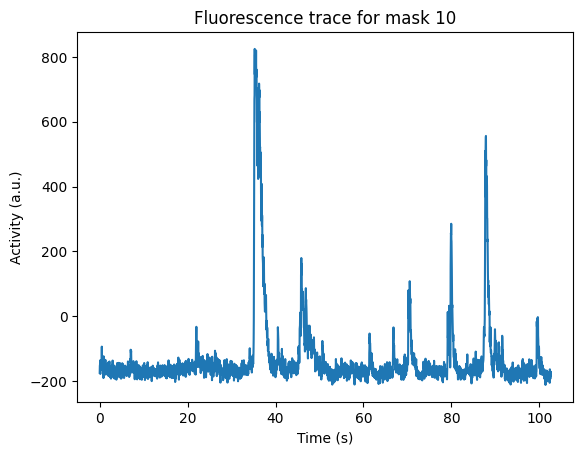

In [43]:
plt.plot(np.r_[: trace.size] * 1 / sampling_rate, trace)
plt.title("Fluorescence trace for mask 10")
plt.xlabel("Time (s)")
plt.ylabel("Activity (a.u.)")

DataJoint queries are a highly flexible tool to manipulate and visualize your data.
After all, visualizing traces or generating rasters is likely just the start of
your analysis workflow. This can also make the queries seem more complex at
first. However, we'll walk through them slowly to simplify their content in this notebook. 

The examples below perform several operations using DataJoint queries:
- Fetch the primary key attributes of the scan with `scan_id=0`.
- Use **multiple restrictions** to fetch the average motion-corrected image for this
  scan with `field_idx=0`.
- Use a **join** operation and **multiple restrictions** to fetch ROI mask coordinates
  and overlay them on the average motion-corrected image.

In [44]:
scan_key = (scan.Scan & "scan_id=0").fetch1("KEY")
average_image = (imaging.MotionCorrection.Summary & scan_key & "field_idx=0").fetch1(
    "average_image"
)

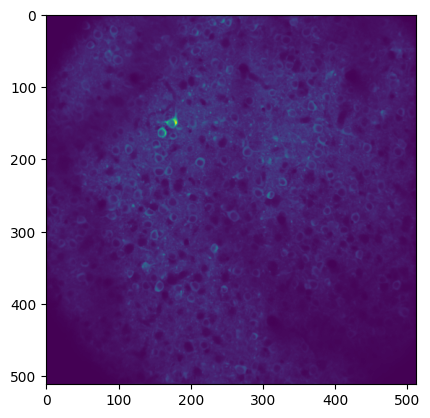

In [45]:
plt.imshow(average_image)

We will fetch mask coordinates and overlay these on the average image.

In [46]:
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & session_key
    & "mask_center_z=0"
    & "mask_npix > 130"
).fetch("mask_xpix", "mask_ypix")

In [47]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

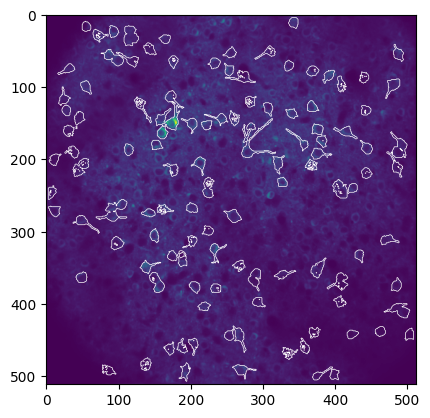

In [48]:
plt.imshow(average_image)
plt.contour(mask_image, colors="white", linewidths=0.5)

This Element includes an interactive widget to plot the segmentations and traces to visualize the results after processing with Suite2p, CaImAn, or EXTRACT.

In [49]:
from element_calcium_imaging.plotting.widget import main

In [50]:
main(imaging)

## Summary

Following this tutorial, we have: 
+ Covered the essential functionality of `element-calcium-imaging`.
+ Learned how to manually insert data into tables.
+ Executed and ingested results of image processing with `suite2p`.
+ Visualized the results. 

#### Documentation and DataJoint Tutorials

+ [Detailed documentation on
  `element-calcium-imaging`.](https://datajoint.com/docs/elements/element-calcium-imaging/)
+ [General `datajoint-python`
  tutorials.](https://github.com/datajoint/datajoint-tutorials) covering fundamentals,
  such as table tiers, query operations, fetch operations, automated computations with the
  make function, and more.
+ [Documentation for
  `datajoint-python`.](https://datajoint.com/docs/core/datajoint-python/)

##### Run this tutorial on your own data

To run this tutorial notebook on your own data, please use the following steps:
+ Download the [mysql-docker image for
  DataJoint](https://github.com/datajoint/mysql-docker) and run the container according
  to the instructions provide in the repository.
+ Create a fork of this repository to your GitHub account.
+ Clone the repository and open the files using your IDE.
+ Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code. 

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

+ Run the code block above and proceed with the rest of the notebook.